<a href="https://colab.research.google.com/github/neel-p8/Stock-Predictions/blob/main/StocksFurther.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier

# sp500 data
sp500 = yf.Ticker("^GSPC")
sp500 = sp500.history(period="max")
sp500.index
#sp500.plot.line(y="Close", use_index=True)
del sp500["Dividends"]
del sp500["Stock Splits"]
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500 = sp500.loc["1990-01-01":].copy()

# Japanese market
nikkei = yf.Ticker("^N225").history(period="max")
del nikkei["Dividends"]
del nikkei["Stock Splits"]
nikkei["Tomorrow"] = nikkei["Close"].shift(-1)
nikkei = nikkei.loc["1990-01-01":].copy()
nikkei['Return'] = nikkei['Close'].pct_change()

# english market
ftse = yf.Ticker("^FTSE").history(period="max")
del ftse["Dividends"]
del ftse["Stock Splits"]
ftse["Tomorrow"] = ftse["Close"].shift(-1)
ftse = ftse.loc["1990-01-01":].copy()
ftse['Return'] = ftse['Close'].pct_change()

# german market
dax = yf.Ticker("^GDAXI").history(period="max")
del dax["Dividends"]
del dax["Stock Splits"]
dax["Tomorrow"] = dax["Close"].shift(-1)
dax = dax.loc["1990-01-01":].copy()
dax['Return'] = dax['Close'].pct_change()

# oil?
oil = yf.Ticker("CL=F").history(period="max")
del oil["Dividends"]
del oil["Stock Splits"]
oil["Tomorrow"] = oil["Close"].shift(-1)
oil = oil.loc["1990-01-01":].copy()
oil["Return"] = oil["Close"].pct_change()

nikkei['Return'] = nikkei['Return'].shift(-1)
ftse['Return'] = ftse['Return'].shift(-1)
dax['Return'] = dax['Return'].shift(-1)
sp500.index = sp500.index.date
nikkei.index = nikkei.index.date
ftse.index = ftse.index.date
dax.index = dax.index.date
oil.index = oil.index.date

sp500['Return_N'] = nikkei['Return']
sp500['Return_F'] = ftse['Return']
sp500['Return_D'] = dax['Return']
sp500['Return_O'] = oil['Return']
sp500 = sp500.dropna()

In [2]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

train = sp500.iloc[:-500]
test = sp500.iloc[-500:]

predictors = ["Close", "Volume", "Open", "High", "Low", "Return_N", "Return_F", "Return_D", "Return_O"]
model.fit(train[predictors], train["Target"])

preds = model.predict(test[predictors])

preds = pd.Series(preds, index=test.index)

precision_score(test["Target"], preds)
combined = pd.concat([test["Target"], preds], axis=1)
#combined.plot()

In [3]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

predictions = backtest(sp500, model, predictors)
predictions["Predictions"].value_counts()
precision_score(predictions["Target"], predictions["Predictions"])

0.709519934906428

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into train+validation set and test set
train_val, test = train_test_split(sp500, test_size=0.2, random_state=1)

# Split the train+validation set into training set and validation set
train, val = train_test_split(train_val, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2

model.fit(train[predictors], train["Target"])
val_preds = model.predict(val[predictors])
print(precision_score(val["Target"], val_preds))

from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
scores = cross_val_score(model, train_val[predictors], train_val["Target"], cv=5, scoring='precision')

# Print the precision for each fold
print(scores)

# Print the average precision
print(scores.mean())

0.7035330261136713
[0.69844358 0.72025052 0.70057582 0.70961145 0.67946257]
0.7016687882691752


In [ ]:
horizons = [2, 5, 60, 250, 1000]
new_predictors = []
for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    new_predictors += [ratio_column, trend_column]

    sp500 = sp500.dropna()

model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors]) [:,1]
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

predictions = backtest(sp500, model, new_predictors)
predictions["Predictions"].value_counts()
precision_score(predictions["Target"], predictions["Predictions"])

### LTSM

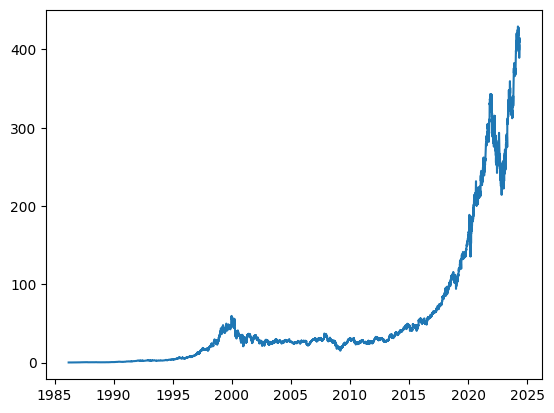

In [5]:
#LTSM
# need to upload csv file for stock

import datetime
import matplotlib.pyplot as plt


df = pd.read_csv('MSFT.csv')
df = df[['Date', 'Close']]
def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
df['Date'] = df['Date'].apply(str_to_datetime)
df.index = df.pop('Date')

plt.plot(df.index, df['Close'])

In [6]:
import numpy as np
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df,
                                '2022-03-18',
                                '2024-04-29',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2022-03-18,287.149994,294.390015,295.220001,300.429993
1,2022-03-21,294.390015,295.220001,300.429993,299.160004
2,2022-03-22,295.220001,300.429993,299.160004,304.059998
3,2022-03-23,300.429993,299.160004,304.059998,299.489990
4,2022-03-24,299.160004,304.059998,299.489990,304.100006
...,...,...,...,...,...
526,2024-04-23,404.269989,399.119995,400.959991,407.570007
527,2024-04-24,399.119995,400.959991,407.570007,409.059998
528,2024-04-25,400.959991,407.570007,409.059998,399.040009
529,2024-04-26,407.570007,409.059998,399.040009,406.320007


Epoch 1/200
14/14 [==============================] - 2s 49ms/step - loss: 82419.2422 - mean_absolute_error: 284.4433 - val_loss: 147151.6875 - val_mean_absolute_error: 383.2969
Epoch 2/200
14/14 [==============================] - 0s 8ms/step - loss: 81741.8672 - mean_absolute_error: 283.2460 - val_loss: 145999.2656 - val_mean_absolute_error: 381.7907
Epoch 3/200
14/14 [==============================] - 0s 7ms/step - loss: 80677.2344 - mean_absolute_error: 281.3574 - val_loss: 144210.5781 - val_mean_absolute_error: 379.4409
Epoch 4/200
14/14 [==============================] - 0s 9ms/step - loss: 79011.5938 - mean_absolute_error: 278.3786 - val_loss: 141386.8281 - val_mean_absolute_error: 375.7014
Epoch 5/200
14/14 [==============================] - 0s 9ms/step - loss: 76397.4453 - mean_absolute_error: 273.6174 - val_loss: 136542.3438 - val_mean_absolute_error: 369.1975
Epoch 6/200
14/14 [==============================] - 0s 9ms/step - loss: 72362.1172 - mean_absolute_error: 266.1634 - v

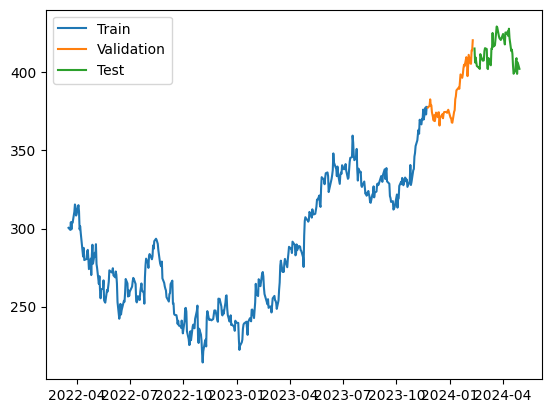

In [7]:
def windowed_df_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()
  dates = df_as_np[:, 0]
  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))
  Y = df_as_np[:, -1]
  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_date_X_y(windowed_df)
dates.shape, X.shape, y.shape

q_80 = int(len(dates) * 0.8)
q_90 = int(len(dates) * 0.9)
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200)

14/14 [==============================] - 0s 2ms/step


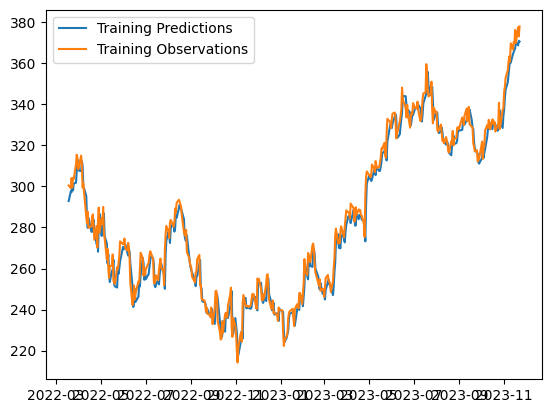

In [8]:
train_predictions = model.predict(X_train).flatten()
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 4ms/step


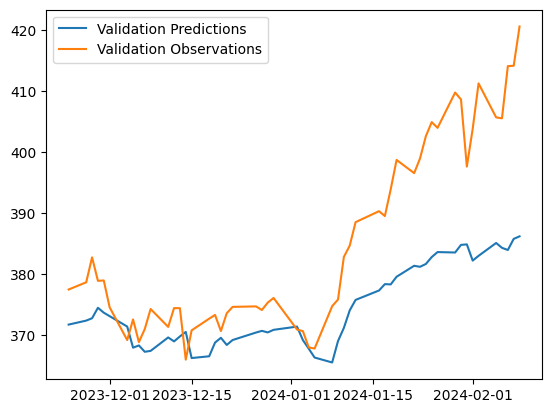

In [10]:
val_predictions = model.predict(X_val).flatten()
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

2/2 [==============================] - 0s 4ms/step


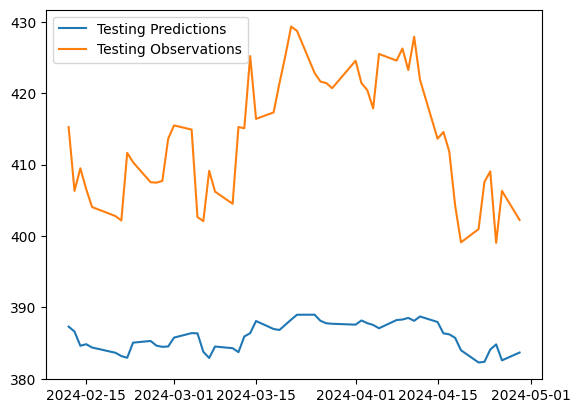

In [11]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

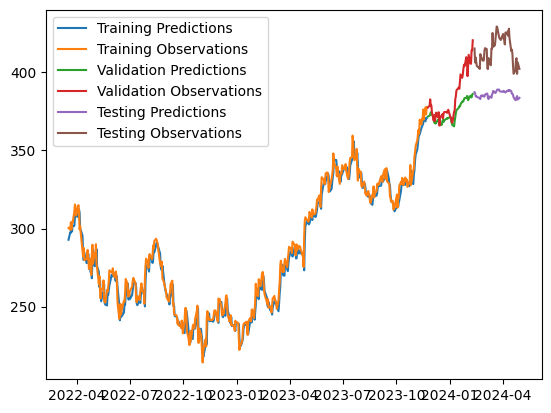

In [12]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

1/1 [==============================] - 0s 17ms/step


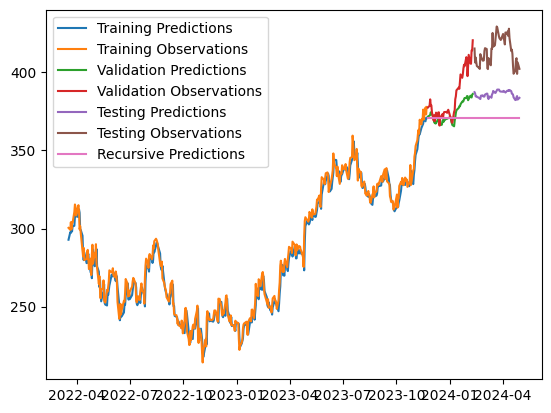

In [13]:
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations',
            'Recursive Predictions'])